In [1]:
!pip install -q transformers[sentencepiece]
!pip install -q datasets
!pip install -q sacrebleu
!pip uninstall -y tqdm
!pip install -q tqdm==4.43.0

     |████████████████████████████████| 2.6 MB 37.0 MB/s 
     |████████████████████████████████| 3.3 MB 46.8 MB/s 
     |████████████████████████████████| 895 kB 52.3 MB/s 
     |████████████████████████████████| 636 kB 52.9 MB/s 
     |████████████████████████████████| 1.1 MB 52.4 MB/s 
     |████████████████████████████████| 542 kB 31.5 MB/s 
     |████████████████████████████████| 76 kB 4.2 MB/s 
     |████████████████████████████████| 243 kB 61.5 MB/s 
     |████████████████████████████████| 118 kB 56.8 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
Found existing installation: tqdm 4.61.2
Uninstalling tqdm-4.61.2:
  Successfully uninstalled tqdm-4.61.2
     |████████████████████████████████| 59 kB 5.8 MB/s 


In [2]:
import tqdm
print(tqdm.__version__)

4.43.0


In [3]:
!nvidia-smi

Fri Jul 23 10:22:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.auto import tqdm
from transformers import MarianConfig,MarianMTModel,MarianTokenizer,DataCollatorForSeq2Seq,AdamW
from datasets import Dataset,load_metric
from sklearn.model_selection import train_test_split
checkpoint = 'Helsinki-NLP/opus-mt-en-fr'

In [5]:
!gdown https://drive.google.com/uc?id=1elHfbHVp-JZ3K5cN-u798Lv0BqFSZMWX

Downloading...
From: https://drive.google.com/uc?id=1elHfbHVp-JZ3K5cN-u798Lv0BqFSZMWX
To: /content/French.xlsx
14.8MB [00:00, 69.1MB/s]


In [6]:
df = pd.read_excel('/content/French.xlsx')
df.head()

,English,French
0,Resumption of the session,Reprise de la session
1,I declare resumed the session of the European ...,Je déclare reprise la session du Parlement eur...
2,"Although, as you will have seen, the dreaded '...","Comme vous avez pu le constater, le grand ""bog..."
3,You have requested a debate on this subject in...,Vous avez souhaité un débat à ce sujet dans le...
4,"In the meantime, I should like to observe a mi...","En attendant, je souhaiterais, comme un certai..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  99914 non-null  object
 1   French   99831 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [8]:
df.isnull().sum()

English     86
French     169
dtype: int64

In [9]:
df.dropna(axis = 0,how = 'any',inplace=True)
df.reset_index(inplace = True)
df.drop('index',axis = 1)
df.head()

,index,English,French
0,0,Resumption of the session,Reprise de la session
1,1,I declare resumed the session of the European ...,Je déclare reprise la session du Parlement eur...
2,2,"Although, as you will have seen, the dreaded '...","Comme vous avez pu le constater, le grand ""bog..."
3,3,You have requested a debate on this subject in...,Vous avez souhaité un débat à ce sujet dans le...
4,4,"In the meantime, I should like to observe a mi...","En attendant, je souhaiterais, comme un certai..."


In [10]:
df.isnull().sum()

index      0
English    0
French     0
dtype: int64

In [11]:
train_df,val_df = train_test_split(df,test_size = 0.2,random_state = 42)
print(train_df.shape)
print(val_df.shape)

(79796, 3)
(19949, 3)


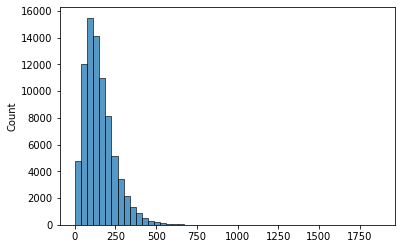

In [12]:
c = []
for i in train_df['English']:
  c.append(len(i))
sns.histplot(c, bins=50, common_norm=False)
plt.show()

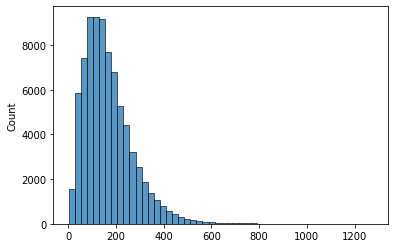

In [13]:
c = []
for i in train_df['French']:
  c.append(len(i))
sns.histplot(c, bins=50, common_norm=False)
plt.show()

In [14]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['index', 'English', 'French', '__index_level_0__'],
    num_rows: 79796
})
Dataset({
    features: ['index', 'English', 'French', '__index_level_0__'],
    num_rows: 19949
})


In [15]:
train_dataset = train_dataset.remove_columns(['index','__index_level_0__'])
val_dataset = val_dataset.remove_columns(['index','__index_level_0__'])

In [16]:
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['English', 'French'],
    num_rows: 79796
})
Dataset({
    features: ['English', 'French'],
    num_rows: 19949
})


In [17]:
tokenizer = MarianTokenizer.from_pretrained(checkpoint)
tokenizer

PreTrainedTokenizer(name_or_path='Helsinki-NLP/opus-mt-en-fr', vocab_size=59514, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

In [18]:
model = MarianMTModel.from_pretrained(checkpoint)
model.config.pad_token_id

59513

In [19]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [20]:
#Hyperparameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
max_length = 512
batch_size = 8
learning_rate = 1e-5

In [21]:
def preprocess(examples,MAX_LENGTH = 512):
  model_inputs = tokenizer(examples['English'],
                           max_length=MAX_LENGTH,
                           padding = 'max_length',
                           truncation=True,
                           return_attention_mask = True)
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(examples['French'],
                        max_length=MAX_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True)
  model_inputs['labels'] = targets['input_ids']
  model_inputs['decoder_input_ids'] = targets['input_ids']
  model_inputs['decoder_attention_mask'] = targets['attention_mask']
  return model_inputs

In [22]:
train_inputs = train_dataset.map(preprocess,batched = True)
val_inputs = val_dataset.map(preprocess,batched = True)

In [23]:
train_inputs = train_inputs.remove_columns(['English','French'])
val_inputs = val_inputs.remove_columns(['English','French'])

In [24]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                       max_length=512,
                                       model = model)

In [25]:
train_dataloader = torch.utils.data.DataLoader(train_inputs,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               collate_fn = data_collator)
val_dataloader = torch.utils.data.DataLoader(val_inputs,
                                               batch_size = batch_size,
                                               shuffle = False,
                                               collate_fn = data_collator)

In [26]:
for batch in train_dataloader:
  break
print(batch['labels'])

tensor([[ 9084,     2,     8,  ..., 59513, 59513, 59513],
        [   60,   325,    15,  ..., 59513, 59513, 59513],
        [   87,     6,  8470,  ..., 59513, 59513, 59513],
        ...,
        [  234,     6,  7688,  ..., 59513, 59513, 59513],
        [  469,  1675,  4988,  ..., 59513, 59513, 59513],
        [   83,   925,    68,  ..., 59513, 59513, 59513]])


In [27]:
del df
del train_df
del val_df
del train_dataset
del val_dataset
del train_inputs
del val_inputs

In [28]:
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
print(num_training_steps)

19950


In [29]:
optimizer = AdamW(model.parameters(),lr = learning_rate)

In [30]:
model.to(device)
progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
  epoch_loss = 0.0
  run_loss = 0.0
  for batch in train_dataloader:
    batch['labels'][batch['labels']==59513] = -100
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    run_loss += loss 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  epoch_loss = run_loss/len(train_dataloader)
  print(100*'-')
  print('Epoch:{}====>Loss:{:.4f}'.format(epoch+1,epoch_loss))

----------------------------------------------------------------------------------------------------
Epoch:1====>Loss:1.1860
----------------------------------------------------------------------------------------------------
Epoch:2====>Loss:1.1034
